In [2]:
from rdkit import Chem
import pathlib
import polaris as po
import fastpdb
import datamol as dm

from tempfile import TemporaryDirectory
import fsspec
import zipfile

competition = po.load_competition("asap-discovery/antiviral-ligand-poses-2025")

[2025-03-13 16:18:27] INFO     The version of Polaris that was used to create the artifact (0.11.0) ]8;id=921999;file:///home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=881227;file:///home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/polaris/_artifact.py#92\92]8;;\
                               is different from the currently installed version of Polaris                        
                               (0.11.9).                                                                           

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=675085;file:///home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=355696;file:///home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/polaris/dataset/_base.py#181\181]8;;\
                               enough, consider caching the dataset first using                                    
                               CompetitionSpecification.cache() for more performant data access.                   

In [4]:
competition.cache()

Copying Zarr archive ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:03:18

            Success: Copying Zarr archive                                                             ]8;id=950170;file:///home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=634240;file:///home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/polaris/utils/context.py#53\53]8;;\

'/home/josh/.cache/polaris/datasets/da428b02-d410-4085-82bc-b4a57eb084c7'

In [5]:
train, test = competition.get_train_test_split()

In [15]:
competition.split

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

In [5]:
import zipfile
# download the ref files so we can align to them
with fsspec.open("https://fs.polarishub.io/2025-01-asap-discovery/ligand_poses_reference_structures.zip") as fd:
    with zipfile.ZipFile(fd, 'r') as zip_ref:
        zip_ref.extractall("./reference_structures/")

In [3]:
import pymol
from rdkit import Chem
from rdkit.Chem import AllChem

def align_training_complex(training_molecule, folder):
    # get the smiles of the training molecule
    smiles = Chem.CanonSmiles(Chem.MolToSmiles(training_molecule))
    best_pose_mol = Chem.MolFromMolFile(str(folder/"best_pose.sdf"), removeHs=False)
    if best_pose_mol is None:
        return False
    
    # look up the complex structure in the competition and write it out
    training_datapoint = None
    for i, train_point in enumerate(train):
        if smiles == train_point[0]["CXSMILES"]:
            print(train_point)
            datapoint = competition[i]
            training_datapoint = datapoint
            break
            
    if training_datapoint is None:
        print("could not find datapoint")
        
    out_file = fastpdb.PDBFile()
    out_file.set_structure(training_datapoint["Complex Structure"])
    out_file.write(folder / "complex_template.pdb")
    
    # taken from the example
    # Let's reset! Just to be sure.
    pymol.cmd.delete("all")

    # Load the reference and mobile structure
    ref_path = "./reference_structures/SARS-CoV-2-Mpro/complex.pdb"
    pymol.cmd.load(ref_path, "reference")
    pymol.cmd.load(folder / "complex_template.pdb", "mobile")

    # Compute the RMSD
    pymol.cmd.rms_cur("mobile", "reference")
    # Now let's align our proteins again using PyMol
    pymol.cmd.align(
        "polymer and name CA and mobile",
        "polymer and name CA and reference",
        quiet=0,
    )
    # write out the aligned structure
    pymol.cmd.select("lig", "resn UNK and mobile")
    ret_path = folder / "aligned_template.sdf"
    pymol.cmd.save(ret_path, "lig")
    aligned_temp_mol = Chem.MolFromMolFile(str(folder/"aligned_template.sdf"))
    # workout the transform between the training mol and the aligned version
    rotation_trans = AllChem.GetAlignmentTransform(training_molecule, aligned_temp_mol)[1]
    AllChem.TransformConformer(best_pose_mol.GetConformer(), rotation_trans)
    Chem.MolToMolFile(best_pose_mol, str(folder/"aligned_best_pose.sdf"))
    return True

In [9]:
for base_folder in ["outputs_fails"]:
    b_folder = pathlib.Path(base_folder)
    for lig_folder in b_folder.glob("*"):
        if "ligand" in lig_folder.name:
            if lig_folder.joinpath("aligned_best_pose.sdf").exists():
                continue
            print("running ", lig_folder)
            mol = Chem.MolFromMolFile(str(lig_folder / "template_lig.sdf"))
            result = align_training_complex(mol, lig_folder)
            print(lig_folder, result)

running  outputs_fails/ligand_7
outputs_fails/ligand_7 False
running  outputs_fails/ligand_10
outputs_fails/ligand_10 False
running  outputs_fails/ligand_1
({'Chain A Sequence': 'SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQC', 'Chain B Sequence': 'SGFRKMAFPSGKVECMVQVTCGTTTLNGLWLDDVVYCPRHVICYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTF', 'Protein Label': 'SARS-CoV-2 Mpro', 'CXSMILES': 'O=C1C[C@]2(CCOc3ccc(Cl)cc32)C(=O)N1c1cncc2ccccc12'}, <rdkit.Chem.rdchem.Mol object at 0x7fb55352ccc0>)
ExecutiveRMS-Error: Atom counts between selecti

ExecutiveRMS-Error: Atom counts between selections don't match (9226 vs 9207)
 Executive: Error -- no atoms left after refinement!
 Match: read scoring matrix.
 Match: assigning 600 x 603 pairwise scores.
 MatchAlign: aligning residues (600 vs 603)...
 MatchAlign: score 3203.500
 ExecutiveAlign: 599 atoms aligned.
 ExecutiveRMS: 7 atoms rejected during cycle 1 (RMSD=0.54).
 ExecutiveRMS: 5 atoms rejected during cycle 2 (RMSD=0.38).
 ExecutiveRMS: 2 atoms rejected during cycle 3 (RMSD=0.37).
 Executive: RMSD =    0.371 (585 to 585 atoms)
outputs_fails/ligand_11 True
running  outputs_fails/ligand_5
({'Chain A Sequence': 'SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ', 'Chain B Sequence': 'SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVI

In [10]:
# loop over the first run folder outputs and build a list of best pose ligands
# then loop over run 2 and overwrite the ligands from the first list
best_poses_by_smiles = {}
for base_folder in ["outputs", "outputs_fails"]:
    b_folder = pathlib.Path(base_folder)
    for lig_folder in b_folder.glob("*"):
        if "ligand" in lig_folder.name:
            # load the best aligned pose
            best_pose_file = lig_folder.joinpath("aligned_best_pose.sdf")
            if best_pose_file.exists():
                best_pose = Chem.MolFromMolFile(str(best_pose_file), removeHs=False)
                smiles = Chem.MolToSmiles(best_pose)
                best_poses_by_smiles[Chem.CanonSmiles(smiles)] = best_pose


In [12]:
len(best_poses_by_smiles)

83

In [16]:
# workout if we have any missing ligands
missing_entries = []
for t in test:
    if t["Protein Label"] == "SARS-CoV-2 Mpro":
        if Chem.CanonSmiles(t["CXSMILES"]) not in best_poses_by_smiles:
            missing_entries.append(t)

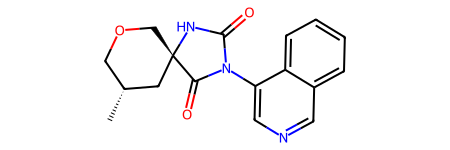

In [30]:
Chem.MolFromSmiles(missing_entries[10]["CXSMILES"])

In [31]:
# write out the best sars ligands
writer = Chem.SDWriter("best_sars.sdf")
for mol in best_poses_by_smiles.values():
    writer.write(mol)